# Description

This notebook contains tools for debugging an individual `CcxtBroker` execution.

The notebook is responsible for aspects of the execution experiment run that are related to the correctness of the execution, as opposed to the analysis of the result:
- Consistency of logging
- Correctness in the submission of orders
- Consistency between trades and submitted orders
- Order time profiling

In [1]:
%load_ext autoreload
%autoreload 2

import logging

import core.config as cconfig
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import im_v2.common.universe as ivcu
import oms.broker.ccxt.ccxt_aggregation_functions as obccagfu
import oms.broker.ccxt.ccxt_execution_quality as obccexqu
import oms.broker.ccxt.ccxt_logger as obcccclo

/app/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-afd8c6ab-0e7d-49b6-9dc3-667262a483de.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.10.0' != container_version='1.12.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CMTask6760_master_broker_debugging_notebook_cleanup'
  hash='67524bdda'
  # Last commits:
    *   67524bdda Daniil Tikhomirov Merge branch 'master' into CMTask6760_master_broker_debugging_notebook_cleanup (13 minutes ago) Thu Jan 11 16:45:54 2024  (HEAD -> CMTask6760_master_broker_debugging_notebook_cleanup, origin/CMTask6760_master_broker_debugging_notebook_cleanup)
    |\  
    | * 889565ece Toma Jordania CmTask6495: dyn

In [3]:
config = cconfig.get_config_from_env()
if config:
    # Get config from env when running the notebook via the `run_notebook.py` script, e.g.
    # in the system reconciliation flow.
    _LOG.info("Using config from env vars")
else:
    system_log_dir = (
        "/shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/"
    )
    config_dict = {"system_log_dir": system_log_dir}
    config = cconfig.Config.from_dict(config_dict)
print(config)

system_log_dir: /shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/


In [4]:
log_dir = config["system_log_dir"]
ccxt_log_reader = obcccclo.CcxtLogger(log_dir)
#
data = ccxt_log_reader.load_all_data(
    convert_to_dataframe=True, abort_on_missing_data=False
)
ccxt_order_response_df = data["ccxt_order_responses"]
ccxt_trades_df = data["ccxt_trades"]
oms_child_order_df = data["oms_child_orders"]
oms_parent_order_df = data["oms_parent_orders"]

WARNING Path '/shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/balances' doesn't exist!
WARNING Path '/shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/reduce_only/ccxt_child_order_responses' doesn't exist!
WARNING Path '/shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/reduce_only/oms_child_orders' doesn't exist!


Loading `/shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/ccxt_child_order_responses` files...:  …

Loading files from '/shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/oms_parent_orders':   0%|   …

Loading `/shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/child_order_fills/ccxt_trades` files...…

Loading `/shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/oms_child_orders` files...:   0%|      …

Loading `/shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/child_order_fills/oms_fills` files...: …

Loading `/shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/child_order_fills/ccxt_fills` files...:…

Loading `/shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/exchange_markets` files...:   0%|      …

Loading `/shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/leverage_info` files...:   0%|         …

Loading `/shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/positions` files...:   0%|          | 0…

WARNING Missing required data for 'balances': continuing as per user request
WARNING Missing required data for 'reduce_only_order_responses': continuing as per user request


In [5]:
# Print the Broker config.
if "broker_config" in data:
    print(hprint.to_pretty_str(data["broker_config"]))
else:
    _LOG.warning("broker_config file not present in %s", log_dir)

{'bid_ask_lookback': '60S',
 'child_order_quantity_computer': {'object_type': 'DynamicSchedulingChildOrderQuantityComputer'},
 'limit_price_computer': {'_volatility_multiple': 0.75,
                          'object_type': 'LimitPriceComputerUsingVolatility'},
 'log_dir': '/data/shared/ecs_tokyo/test/broker_only/2024/01/09/20240109_2',
 'raw_data_reader': 'RawDataReader',
 'secret_identifier': 'binance.preprod.trading.4',
 'stage': 'preprod',
 'universe_version': 'v7.4'}


In [6]:
# Print the used Config, if any.
experiment_config = obcccclo.load_config_for_execution_analysis(log_dir)
print(experiment_config)

INFO  Loading config from /shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/system_config.output.values_as_strings.pkl
WARNING Config file /shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/system_config.output.values_as_strings.pkl does not exist
None


In [7]:
ccxt_order_response_df.head(3)

,info,order,client_order_id,timestamp,datetime,last_trade_timestamp,lastUpdateTimestamp,symbol,order_type,time_in_force,post_only,reduce_only,side,order_price,triggerPrice,order_amount,cost,average,filled,remaining,status,fee,trades,fees,stop_price,takeProfitPrice,stopLossPrice,order_update_timestamp,order_update_datetime
0,"{'orderId': '13328254963', 'symbol': 'GMTUSDT'...",13328254963,x-xcKtGhcu9da579d8be05e128bd98b3,1704780001634,2024-01-09T06:00:01.634Z,NaN,1704780001634,GMT/USDT:USDT,limit,GTC,False,False,buy,0.3520,None,282.0,0.0,NaN,0.0,282.0,open,"{'currency': None, 'cost': None, 'rate': None}",[],"[{'currency': None, 'cost': None, 'rate': None}]",None,None,None,1704780001634,2024-01-09 06:00:01.634000+00:00
1,"{'orderId': '13328313357', 'symbol': 'GMTUSDT'...",13328313357,x-xcKtGhcue2f2e253d513ccb79a3307,1704780300690,2024-01-09T06:05:00.690Z,NaN,1704780300690,GMT/USDT:USDT,limit,GTC,False,False,sell,0.3517,None,152.0,0.0,NaN,0.0,152.0,open,"{'currency': None, 'cost': None, 'rate': None}",[],"[{'currency': None, 'cost': None, 'rate': None}]",None,None,None,1704780300690,2024-01-09 06:05:00.690000+00:00
2,"{'orderId': '13328322908', 'symbol': 'GMTUSDT'...",13328322908,x-xcKtGhcu19cf88f3440b016c3fc762,1704780360616,2024-01-09T06:06:00.616Z,NaN,1704780360616,GMT/USDT:USDT,limit,GTC,False,False,sell,0.3507,None,152.0,0.0,NaN,0.0,152.0,open,"{'currency': None, 'cost': None, 'rate': None}",[],"[{'currency': None, 'cost': None, 'rate': None}]",None,None,None,1704780360616,2024-01-09 06:06:00.616000+00:00


## Child order responses

In [8]:
ccxt_order_response_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   info                    158 non-null    object             
 1   order                   158 non-null    int64              
 2   client_order_id         158 non-null    object             
 3   timestamp               158 non-null    int64              
 4   datetime                158 non-null    object             
 5   last_trade_timestamp    1 non-null      float64            
 6   lastUpdateTimestamp     158 non-null    int64              
 7   symbol                  158 non-null    object             
 8   order_type              158 non-null    object             
 9   time_in_force           158 non-null    object             
 10  post_only               158 non-null    bool               
 11  reduce_only             158 non-null    bool 

## Child orders

In [9]:
oms_child_order_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158 entries, 13 to 219
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   creation_timestamp         158 non-null    datetime64[ns, UTC]
 1   asset_id                   158 non-null    int64              
 2   type_                      158 non-null    object             
 3   start_timestamp            158 non-null    datetime64[ns, UTC]
 4   end_timestamp              158 non-null    datetime64[ns, UTC]
 5   curr_num_shares            158 non-null    float64            
 6   diff_num_shares            158 non-null    float64            
 7   tz                         158 non-null    object             
 8   extra_params               158 non-null    object             
 9   volatility_multiple        158 non-null    float64            
 10  wave_id                    158 non-null    int64              
 11  num_data_p

In [10]:
oms_child_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,volatility_multiple,wave_id,num_data_points,exchange_timestamp,knowledge_timestamp,end_download_timestamp,latest_bid_size,latest_ask_size,num_data_points_resampled,scaling_multiplier,bid_vol,bid_vol_bps,latest_bid_price,ask_vol,ask_vol_bps,latest_ask_price,total_vol,latest_mid_price,total_vol_bps,spread,spread_bps,total_vol_to_spread_bps,limit_price,ccxt_id,name,attempt_num
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,2024-01-09 06:00:00.675828+00:00,1030828978,limit,2024-01-09 06:00:00.675828+00:00,2024-01-09 06:01:00+00:00,0.0,282.0,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.75,0,278,2024-01-09 05:59:59.818000+00:00,2024-01-09 05:59:59.851866+00:00,2024-01-09 05:59:59.839134+00:00,12664.0,23510.0,598,24.494897,0.000549,15.586064,0.3523,0.000549,15.581641,0.3524,0.000549,0.35235,15.583852,0.0001,2.838087,5.490970,0.3520,13328254963,13,1
43,2024-01-09 06:05:00.616654+00:00,1030828978,limit,2024-01-09 06:05:00.616654+00:00,2024-01-09 06:06:00+00:00,282.0,-152.0,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.75,0,296,2024-01-09 06:05:00.079000+00:00,2024-01-09 06:05:00.192690+00:00,2024-01-09 06:05:00.179842+00:00,47867.0,11835.0,597,24.494897,0.000471,13.396325,0.3513,0.000471,13.392513,0.3514,0.000471,0.35135,13.394419,0.0001,2.846165,4.706129,0.3517,13328313357,43,1
51,2024-01-09 06:06:00.555679+00:00,1030828978,limit,2024-01-09 06:06:00.555679+00:00,2024-01-09 06:07:00+00:00,282.0,-152.0,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.75,1,286,2024-01-09 06:05:59.947000+00:00,2024-01-09 06:06:00.085575+00:00,2024-01-09 06:06:00.073519+00:00,7507.0,12017.0,598,24.494897,0.000459,13.110945,0.3504,0.000459,13.107205,0.3505,0.000459,0.35045,13.109075,0.0001,2.853474,4.594075,0.3507,13328322908,51,1


### Extract the OMS parent order ID

In [12]:
oms_child_order_df["parent_order_id"] = oms_child_order_df["extra_params"].apply(
    lambda x: x["oms_parent_order_id"]
)
oms_child_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,volatility_multiple,wave_id,num_data_points,exchange_timestamp,knowledge_timestamp,end_download_timestamp,latest_bid_size,latest_ask_size,num_data_points_resampled,scaling_multiplier,bid_vol,bid_vol_bps,latest_bid_price,ask_vol,ask_vol_bps,latest_ask_price,total_vol,latest_mid_price,total_vol_bps,spread,spread_bps,total_vol_to_spread_bps,limit_price,ccxt_id,name,attempt_num,parent_order_id
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,2024-01-09 06:00:00.675828+00:00,1030828978,limit,2024-01-09 06:00:00.675828+00:00,2024-01-09 06:01:00+00:00,0.0,282.0,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.75,0,278,2024-01-09 05:59:59.818000+00:00,2024-01-09 05:59:59.851866+00:00,2024-01-09 05:59:59.839134+00:00,12664.0,23510.0,598,24.494897,0.000549,15.586064,0.3523,0.000549,15.581641,0.3524,0.000549,0.35235,15.583852,0.0001,2.838087,5.490970,0.3520,13328254963,13,1,3
43,2024-01-09 06:05:00.616654+00:00,1030828978,limit,2024-01-09 06:05:00.616654+00:00,2024-01-09 06:06:00+00:00,282.0,-152.0,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.75,0,296,2024-01-09 06:05:00.079000+00:00,2024-01-09 06:05:00.192690+00:00,2024-01-09 06:05:00.179842+00:00,47867.0,11835.0,597,24.494897,0.000471,13.396325,0.3513,0.000471,13.392513,0.3514,0.000471,0.35135,13.394419,0.0001,2.846165,4.706129,0.3517,13328313357,43,1,33
51,2024-01-09 06:06:00.555679+00:00,1030828978,limit,2024-01-09 06:06:00.555679+00:00,2024-01-09 06:07:00+00:00,282.0,-152.0,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.75,1,286,2024-01-09 06:05:59.947000+00:00,2024-01-09 06:06:00.085575+00:00,2024-01-09 06:06:00.073519+00:00,7507.0,12017.0,598,24.494897,0.000459,13.110945,0.3504,0.000459,13.107205,0.3505,0.000459,0.35045,13.109075,0.0001,2.853474,4.594075,0.3507,13328322908,51,1,33


In [13]:
# Check how many child orders are generated per parent_order_id.
oms_child_order_df["parent_order_id"].value_counts().value_counts()

count
1    30
2    13
3    13
5     7
4     7
Name: count, dtype: int64

### Check the error messages in non-submitted orders.

In [14]:
# Select the OMS child orders with no CCXT ID and check their error messages.
not_submitted_oms_child_order_df = oms_child_order_df.loc[
    oms_child_order_df["ccxt_id"] == -1
]
print(
    f"Number of not submitted OMS child orders={not_submitted_oms_child_order_df.shape[0]} \
    out of total orders={oms_child_order_df.shape[0]}"
)

Number of not submitted OMS child orders=0     out of total orders=158


In [15]:
# Extract all error messages from unsubmitted orders.
not_submitted_oms_child_order_df["error_msg"] = not_submitted_oms_child_order_df[
    "extra_params"
].apply(lambda x: x["error_msg"])

In [16]:
# Display error messages grouped by symbol.
# Get the universe to map asset_id's.
universe = ivcu.get_vendor_universe("CCXT", "trade", as_full_symbol=True)
asset_id_to_symbol_mapping = ivcu.build_numerical_to_string_id_mapping(universe)
not_submitted_oms_child_order_df[
    "full_symbol"
] = not_submitted_oms_child_order_df["asset_id"].map(asset_id_to_symbol_mapping)
# Get value counts of error messages.
error_msg = not_submitted_oms_child_order_df.groupby("full_symbol")[
    "error_msg"
].value_counts()
error_msg

Series([], Name: count, dtype: int64)

### Check the buy and sell orders with max notional

In [17]:
oms_child_order_notionals = (
    oms_child_order_df["diff_num_shares"] * oms_child_order_df["limit_price"]
)
max_sell_notional = oms_child_order_notionals[oms_child_order_notionals < 0].min()
max_buy_notional = oms_child_order_notionals[oms_child_order_notionals > 0].max()
_LOG.info(
    "Max sell notional: %s\nMax buy notional: %s",
    max_sell_notional,
    max_buy_notional,
)

INFO  Max sell notional: -99.17430000000002
Max buy notional: 99.264


## Parent orders

In [18]:
oms_parent_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params
order_id,,,,,,,,,
0,2024-01-09 06:00:00+00:00,1464553467,price@twap,2024-01-09 06:00:00+00:00,2024-01-09 06:05:00+00:00,0.0,-0.032471,UTC,"{'ccxt_symbol': 'ETH/USDT:USDT', 'stats': {'_s..."
1,2024-01-09 06:00:00+00:00,4516629366,price@twap,2024-01-09 06:00:00+00:00,2024-01-09 06:05:00+00:00,0.0,196.835199,UTC,"{'ccxt_symbol': 'SAND/USDT:USDT', 'stats': {'_..."
2,2024-01-09 06:00:00+00:00,2425308589,price@twap,2024-01-09 06:00:00+00:00,2024-01-09 06:05:00+00:00,0.0,111.948231,UTC,"{'ccxt_symbol': 'STORJ/USDT:USDT', 'stats': {'..."


In [19]:
# Extract `ccxt_id` of child orders into a separate column.
oms_parent_order_df["child_order_ccxt_ids"] = oms_parent_order_df[
    "extra_params"
].apply(lambda x: x["ccxt_id"])
oms_parent_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,child_order_ccxt_ids
order_id,,,,,,,,,,
0,2024-01-09 06:00:00+00:00,1464553467,price@twap,2024-01-09 06:00:00+00:00,2024-01-09 06:05:00+00:00,0.0,-0.032471,UTC,"{'ccxt_symbol': 'ETH/USDT:USDT', 'stats': {'_s...","[8389765641529362073, 8389765641529524939, 838..."
1,2024-01-09 06:00:00+00:00,4516629366,price@twap,2024-01-09 06:00:00+00:00,2024-01-09 06:05:00+00:00,0.0,196.835199,UTC,"{'ccxt_symbol': 'SAND/USDT:USDT', 'stats': {'_...",[15101905458]
2,2024-01-09 06:00:00+00:00,2425308589,price@twap,2024-01-09 06:00:00+00:00,2024-01-09 06:05:00+00:00,0.0,111.948231,UTC,"{'ccxt_symbol': 'STORJ/USDT:USDT', 'stats': {'...",[7375710670]


In [20]:
# Check how many child orders per parent order were successfully submitted.
# A value between maximum expected and 0 can mean that some child orders
# could not get through, while otherwise being well-formed.
# A value of 0 means that the parent order had an issue, e.g.
# having a notional that made all child orders below a minimum.
oms_parent_order_df["submitted_child_order_num"] = oms_parent_order_df[
    "child_order_ccxt_ids"
].str.len()
oms_parent_order_df["submitted_child_order_num"].value_counts()

submitted_child_order_num
1    30
2    13
3    13
4     7
5     7
Name: count, dtype: int64

## Trades

In [21]:
ccxt_trades_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2024-01-09 06:00:07.720000+00:00 to 2024-01-09 06:34:09.990000+00:00
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   timestamp         72 non-null     datetime64[ns, UTC]
 1   datetime          72 non-null     datetime64[ns, UTC]
 2   symbol            72 non-null     object             
 3   asset_id          72 non-null     int64              
 4   id                72 non-null     int64              
 5   order             72 non-null     int64              
 6   side              72 non-null     object             
 7   takerOrMaker      72 non-null     object             
 8   price             72 non-null     float64            
 9   amount            72 non-null     float64            
 10  cost              72 non-null     float64            
 11  transaction_cost  72 non-null     float64            
 12  fe

### Verify that all trades correspond to logged child orders

In [22]:
# Verify that all trades have an associated order response.
# If the trade does not have an associated order, it means
# that a trade was executed that was not accounted for during the experiment.
all(ccxt_trades_df["order"].isin(ccxt_order_response_df["order"]))

True

In [23]:
# Verify that all trades have an associated 'ccxt_id' in OMS child orders.
# This verifies that there is a consistency between a CCXT order, OMS order and
# a CCXT trade. If a trade has no associated OMS child order `ccxt_id`, it means
# that an unexpected trade was executed, for example, by a different actor on the same account.
all(ccxt_trades_df["order"].isin(oms_child_order_df["ccxt_id"]))

True

### Check orders that do not correspond to any trades

In [24]:
# Existence of such orders is not necessarily a bug.
# It means that a given OMS child order was not filled.
child_orders_with_no_trades = ~oms_child_order_df["ccxt_id"].isin(
    ccxt_trades_df["order"]
)
child_orders_with_no_trades.sum()

92

### Check the correctness of trade amount

In [25]:
# If the traded amount is larger than the order, it means that an extra trade
# is executed and the order is filled for a larger amount.
# This can mean an accounting error on the exchange side.
trade_amount_by_order = ccxt_trades_df.groupby("order").agg({"amount": "sum"})
accepted_child_order_df = oms_child_order_df.loc[
    oms_child_order_df["ccxt_id"] != -1
]
trade_amount_by_order["child_order_amount"] = accepted_child_order_df.set_index(
    "ccxt_id"
)["diff_num_shares"].abs()

In [26]:
mask = (
    trade_amount_by_order["amount"] > trade_amount_by_order["child_order_amount"]
)
trade_amount_by_order.loc[mask]

,amount,child_order_amount
order,,


In [27]:
# Check the difference between the filled amount and the agg child order quantities.
trade_amount_by_order["diff"] = (
    trade_amount_by_order["child_order_amount"] - trade_amount_by_order["amount"]
)
trade_amount_by_order = trade_amount_by_order.rename(
    {"amount": "aggregated_trades_quantity"}, axis=1
)
trade_amount_by_order = trade_amount_by_order[
    ["child_order_amount", "aggregated_trades_quantity", "diff"]
]
trade_amount_by_order[trade_amount_by_order["diff"] > 0]

,child_order_amount,aggregated_trades_quantity,diff
order,,,


### Verify that CCXT IDs are equal in both child orders and responses

In [28]:
# Verify that we are not logging any CCXT orders that are not a part
# of the experiment, i.e. have no OMS order associated with it.
# We expect all retrieved responses to be a subset of CCXT IDs
# connected to the OMS child orders.
submitted_oms_orders_ccxt_ids = set(
    oms_child_order_df.loc[oms_child_order_df["ccxt_id"] != -1][
        "ccxt_id"
    ].unique()
)
ccxt_response_ids = set(ccxt_order_response_df["order"].unique())
ccxt_response_ids.issubset(submitted_oms_orders_ccxt_ids)

True

# Group trades by order

In [29]:
# Aggregate fills by order.
ccxt_trades_by_order = obccagfu.aggregate_fills_by_order(ccxt_trades_df)
ccxt_trades_by_order.head(3)

,first_timestamp,last_timestamp,first_datetime,last_datetime,symbol,asset_id,buy_count,sell_count,taker_count,maker_count,buy_volume,sell_volume,taker_volume,maker_volume,buy_notional,sell_notional,taker_notional,maker_notional,price,amount,cost,transaction_cost,realized_pnl
order,,,,,,,,,,,,,,,,,,,,,,,
7375710670,2024-01-09 06:00:40.112000+00:00,2024-01-09 06:00:40.112000+00:00,2024-01-09 06:00:40.112000+00:00,2024-01-09 06:00:40.112000+00:00,STORJ/USDT:USDT,2425308589,1,0,0,1,111.0,0.0,0.0,111.0,67.1439,0.0000,0.0,67.1439,0.6049,111.0,67.1439,0.013429,0.0000
7375729349,2024-01-09 06:05:29.829000+00:00,2024-01-09 06:05:29.829000+00:00,2024-01-09 06:05:29.829000+00:00,2024-01-09 06:05:29.829000+00:00,STORJ/USDT:USDT,2425308589,0,1,0,1,0.0,152.0,0.0,152.0,0.0000,91.7776,0.0,91.7776,0.6038,152.0,91.7776,0.018356,-0.1221
7375753462,2024-01-09 06:11:11.191000+00:00,2024-01-09 06:11:11.191000+00:00,2024-01-09 06:11:11.191000+00:00,2024-01-09 06:11:11.191000+00:00,STORJ/USDT:USDT,2425308589,1,0,0,1,164.0,0.0,0.0,164.0,98.9412,0.0000,0.0,98.9412,0.6033,164.0,98.9412,0.019788,0.0205


# Time profiling for child orders

In [30]:
oms_child_order_df_unpacked = ccxt_log_reader.load_oms_child_order(
    unpack_extra_params=True, convert_to_dataframe=True
)

Loading `/shared_data/ecs/test/tokyo_broker_only/2024/01/09/20240109_2/oms_child_orders` files...:   0%|      …

In [31]:
# Get the number of child orders per wave as determined by the number of unique assets.
wave = obccexqu.get_oms_child_order_timestamps(oms_child_order_df_unpacked)

In [32]:
wave.head(3)

,exchange_timestamp,end_download_timestamp,knowledge_timestamp,stats__submit_twap_child_order::bid_ask_market_data.start,stats__submit_twap_child_order::bid_ask_market_data.done,stats__submit_twap_child_order::get_open_positions.done,stats__submit_twap_child_order::child_order.created,stats__submit_twap_child_order::child_order.limit_price_calculated,stats__submit_single_order_to_ccxt::start.timestamp,stats__submit_single_order_to_ccxt::all_attempts_end.timestamp,stats__submit_twap_child_order::child_order.submitted
order_id,,,,,,,,,,,
13,2024-01-09 05:59:59.818000+00:00,2024-01-09 05:59:59.839134+00:00,2024-01-09 05:59:59.851866+00:00,2024-01-09 06:00:00.020168+00:00,2024-01-09 06:00:00.638071+00:00,2024-01-09 06:00:00.016721+00:00,2024-01-09 06:00:00.677236+00:00,2024-01-09 06:00:00.682116+00:00,2024-01-09 06:00:00.682912+00:00,2024-01-09 06:00:01.739348+00:00,2024-01-09 06:00:01.739708+00:00
43,2024-01-09 06:05:00.079000+00:00,2024-01-09 06:05:00.179842+00:00,2024-01-09 06:05:00.192690+00:00,2024-01-09 06:05:00.252358+00:00,2024-01-09 06:05:00.576822+00:00,2024-01-09 06:05:00.248453+00:00,2024-01-09 06:05:00.618246+00:00,2024-01-09 06:05:00.623311+00:00,2024-01-09 06:05:00.624195+00:00,2024-01-09 06:05:00.856795+00:00,2024-01-09 06:05:00.857140+00:00
51,2024-01-09 06:05:59.947000+00:00,2024-01-09 06:06:00.073519+00:00,2024-01-09 06:06:00.085575+00:00,2024-01-09 06:06:00.153921+00:00,2024-01-09 06:06:00.530155+00:00,2024-01-09 06:06:00.149129+00:00,2024-01-09 06:06:00.557349+00:00,2024-01-09 06:06:00.562594+00:00,2024-01-09 06:06:00.563487+00:00,2024-01-09 06:06:00.659903+00:00,2024-01-09 06:06:00.660223+00:00


In [33]:
# Sort the events (column names) in chronological order.
wave = wave.sort_values(wave.first_valid_index(), axis=1)
time_delays = obccexqu.get_time_delay_between_events(wave)

<Axes: ylabel='Time delay'>

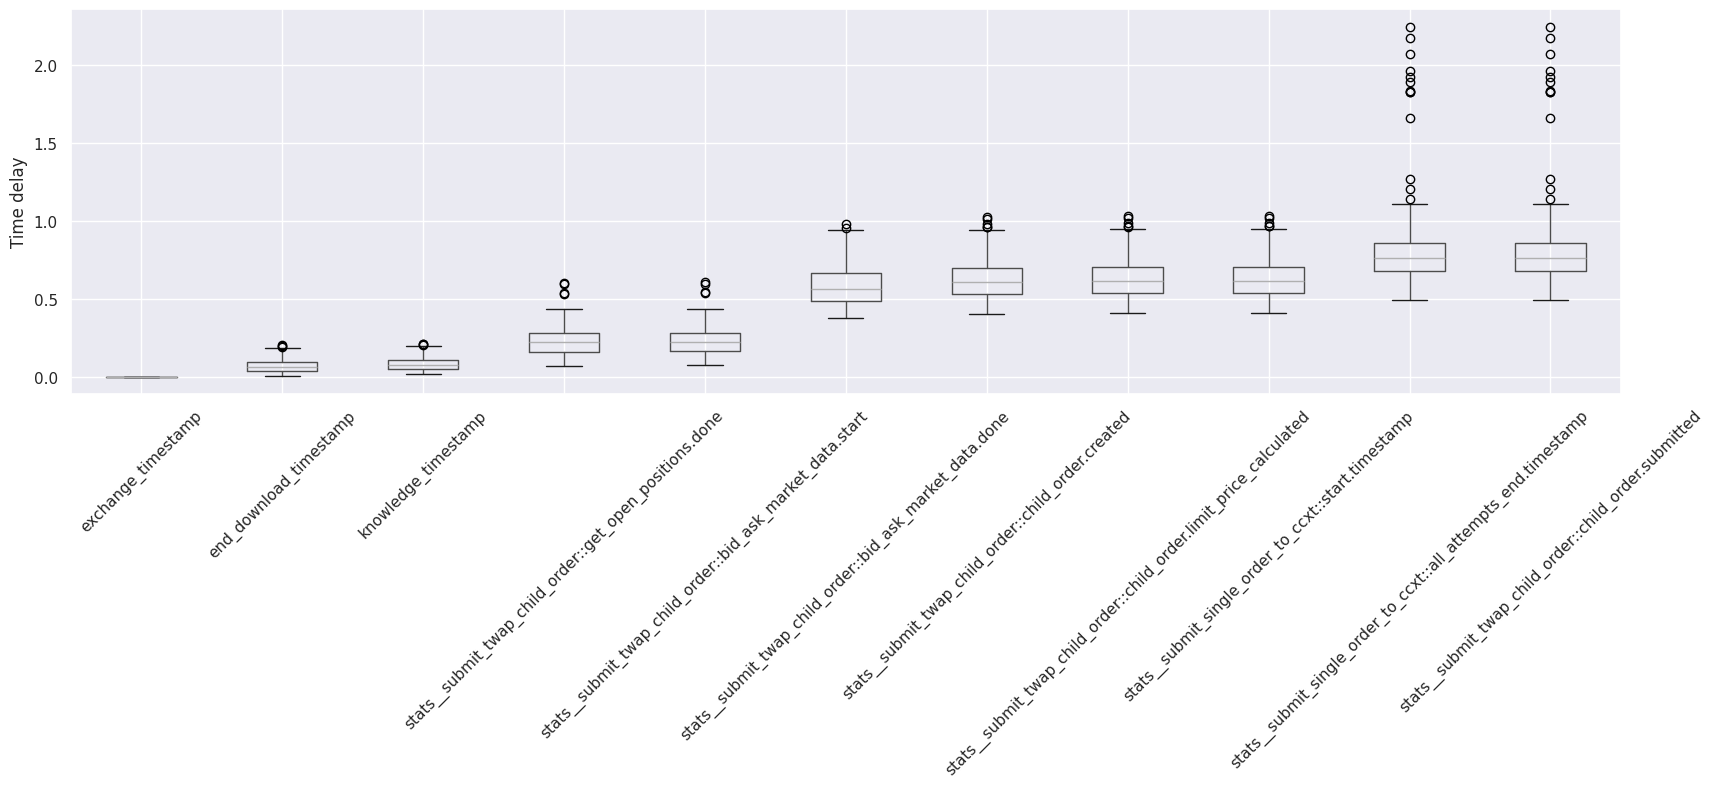

In [34]:
time_delays.boxplot(rot=45, ylabel="Time delay")